In [1]:
from google.colab import files
uploaded = files.upload()


Saving housing.csv to housing.csv


In [2]:
import pandas as pd
df = pd.read_csv("housing.csv")

In [3]:
df.shape

(20640, 10)

In [4]:
print("Total variables (columns):", df.shape[1])
print("Variable names:\n", df.columns.tolist())

Total variables (columns): 10
Variable names:
 ['longitude', 'latitude', 'housing_median_age', 'total_rooms', 'total_bedrooms', 'population', 'households', 'median_income', 'median_house_value', 'ocean_proximity']


In [5]:
df.dtypes

,0
longitude,float64
latitude,float64
housing_median_age,float64
total_rooms,float64
total_bedrooms,float64
population,float64
households,float64
median_income,float64
median_house_value,float64
ocean_proximity,object


In [6]:
categorical_cols = df.select_dtypes(include=['object']).columns
for col in categorical_cols:
    print(f"\nUnique values in '{col}':")
    print(df[col].unique())


Unique values in 'ocean_proximity':
['NEAR BAY' '<1H OCEAN' 'INLAND' 'NEAR OCEAN' 'ISLAND']


In [7]:
df_cleaned = df.dropna()
print("New shape after dropping rows with NA values:", df_cleaned.shape)

New shape after dropping rows with NA values: (20433, 10)


In [8]:
display(df_cleaned.describe().T[['mean', 'std', 'min', '50%', 'max']])

skew_vals = df_cleaned.select_dtypes('number').skew().sort_values(ascending=False)
print("Skewness (descending):\n", skew_vals)

,mean,std,min,50%,max
longitude,-119.570689,2.003578,-124.3500,-118.4900,-114.3100
latitude,35.633221,2.136348,32.5400,34.2600,41.9500
housing_median_age,28.633094,12.591805,1.0000,29.0000,52.0000
total_rooms,2636.504233,2185.269567,2.0000,2127.0000,39320.0000
total_bedrooms,537.870553,421.385070,1.0000,435.0000,6445.0000
population,1424.946949,1133.208490,3.0000,1166.0000,35682.0000
households,499.433465,382.299226,1.0000,409.0000,6082.0000
median_income,3.871162,1.899291,0.4999,3.5365,15.0001
median_house_value,206864.413155,115435.667099,14999.0000,179700.0000,500001.0000


Skewness (descending):
 population            4.960017
total_rooms           4.158816
total_bedrooms        3.459546
households            3.413850
median_income         1.644557
median_house_value    0.978290
latitude              0.464934
housing_median_age    0.061605
longitude            -0.296141
dtype: float64


# Relationship Between Income and House Value
The scatterplot of median_income versus median_house_value reveals a strong positive relationship:

Higher median incomes are generally associated with higher house prices.

However, the relationship is non-linear — after a certain income level (~6 units), the house values appear to plateau at around $500,000, which suggests a ceiling effect.
(This is consistent with the historical capping of the target variable in the California Housing dataset.)

Some high-income tracts (>8) still have moderate house values, implying that other factors (e.g., location, housing stock) also play a role.

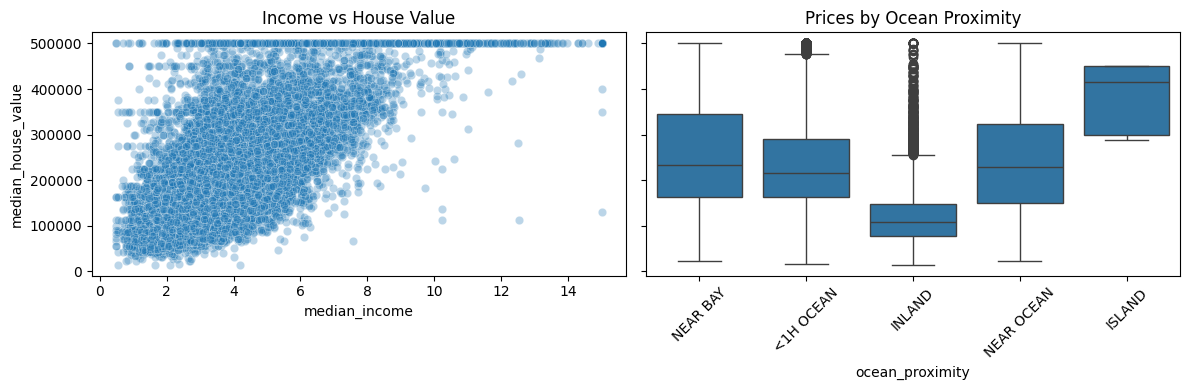

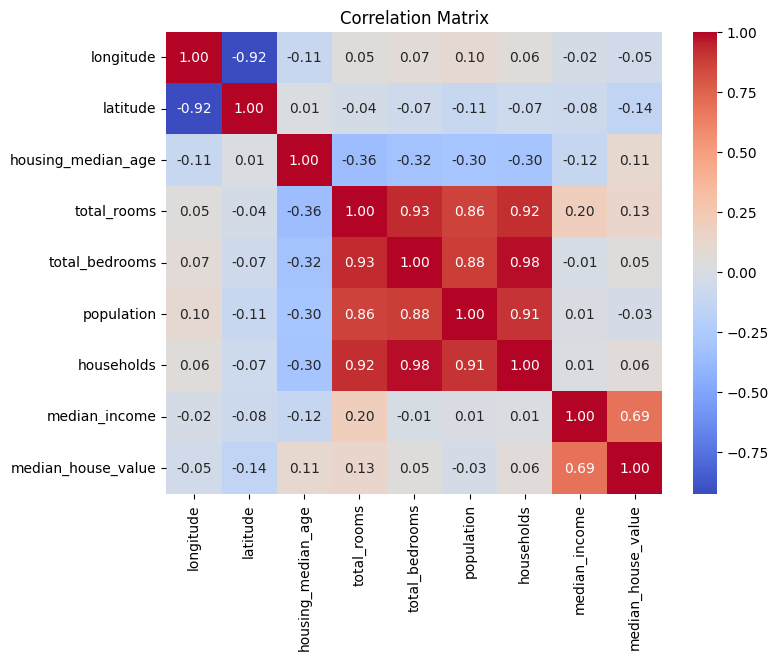

In [9]:
import matplotlib.pyplot as plt
import seaborn as sns

fig, ax = plt.subplots(1, 2, figsize=(12,4), sharey=True)
sns.scatterplot(data=df_cleaned, x='median_income', y='median_house_value',
                alpha=0.3, ax=ax[0])
ax[0].set_title('Income vs House Value')

sns.boxplot(data=df_cleaned, x='ocean_proximity', y='median_house_value', ax=ax[1])
ax[1].set_title('Prices by Ocean Proximity')
ax[1].tick_params(axis='x', rotation=45)
plt.tight_layout()
plt.show()

# Correlation
num_cols = df_cleaned.select_dtypes('number').columns
plt.figure(figsize=(8,6))
sns.heatmap(df_cleaned[num_cols].corr(), cmap='coolwarm', annot=True, fmt=".2f")
plt.title('Correlation Matrix')
plt.show()


In [10]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LinearRegression
from sklearn.metrics import root_mean_squared_error, r2_score
from sklearn.model_selection import train_test_split

y = df_cleaned['median_house_value']
X = df_cleaned.drop('median_house_value', axis=1)

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

numerical_features = ['housing_median_age', 'total_rooms', 'total_bedrooms',
                      'population', 'households', 'median_income']
categorical_features = ['ocean_proximity']

preprocess = ColumnTransformer(
    transformers=[
        ('num', StandardScaler(), numerical_features),
        ('cat', OneHotEncoder(handle_unknown='ignore'), categorical_features)
    ])

lr_pipe = Pipeline([
    ('prep', preprocess),
    ('model', LinearRegression())
])

lr_pipe.fit(X_train, y_train)

preds = lr_pipe.predict(X_test)
rmse = root_mean_squared_error(y_test, preds)
r2 = r2_score(y_test, preds)

print(f"Linear Regression — RMSE: {rmse:,.0f} | R²: {r2:.3f}")

Linear Regression — RMSE: 70,322 | R²: 0.638


In [11]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

ohe_cols = lr_pipe.named_steps['prep'] \
                  .named_transformers_['cat'] \
                  .get_feature_names_out(['ocean_proximity'])

num_features = ['housing_median_age', 'total_rooms', 'total_bedrooms',
                      'population', 'households', 'median_income']

feature_names = np.concatenate([ohe_cols, num_features])

coefs = pd.Series(lr_pipe.named_steps['model'].coef_, index=feature_names)
coefs_sorted = coefs.reindex(coefs.abs().sort_values(ascending=False).index)

print("Top 10 strongest linear effects:")
display(coefs_sorted.head(10))


Top 10 strongest linear effects:


,0
population,198254.089307
total_bedrooms,-104461.005757
housing_median_age,76856.931163
ocean_proximity_NEAR BAY,-39913.682534
total_rooms,-36170.058488
ocean_proximity_ISLAND,35198.960219
households,-33818.458631
ocean_proximity_NEAR OCEAN,26210.997628
median_income,-23804.566431
ocean_proximity_INLAND,-16353.063463


Random Forest — RMSE: 61,300 | R²: 0.725
Gradient Boost — RMSE: 62,574 | R²: 0.714
Ridge         — RMSE: 70,277 | R²: 0.639


,Model,RMSE,R²
0,Random Forest,61299.708853,0.725221
1,Gradient Boost,62574.489800,0.713673
2,Ridge,70276.694304,0.638848


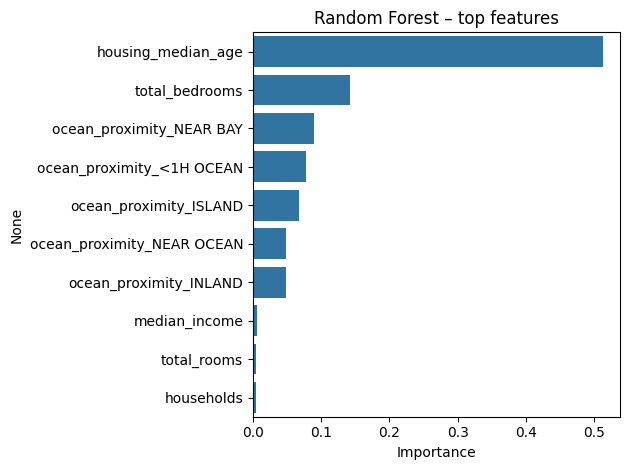

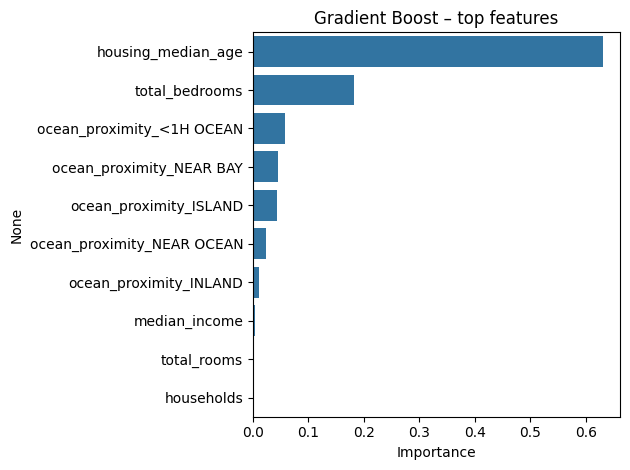

In [12]:
#  Model comparison: Random Forest, Gradient Boosting, Ridge

import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.model_selection import train_test_split
from sklearn.metrics import root_mean_squared_error, r2_score

from sklearn.ensemble import RandomForestRegressor, GradientBoostingRegressor
from sklearn.linear_model import Ridge


try:
    X_train
except NameError:
    cat_features = ['ocean_proximity']
    num_features = df_cleaned.columns.difference(['median_house_value', 'ocean_proximity'])

    preprocess = ColumnTransformer([
        ('cat', OneHotEncoder(drop='first'), cat_features),
        ('num', 'passthrough', num_features)
    ])

    X = df_cleaned.drop(columns='median_house_value')
    y = df_cleaned['median_house_value']

    X_train, X_test, y_train, y_test = train_test_split(
        X, y, test_size=0.20, random_state=42)

models = {
    "Random Forest": RandomForestRegressor(
        n_estimators=400, n_jobs=-1, random_state=42),
    "Gradient Boost": GradientBoostingRegressor(
        n_estimators=400, learning_rate=0.05, max_depth=3, random_state=42),
    "Ridge": Ridge(alpha=1.0)
}

records = []

for name, est in models.items():
    pipe = Pipeline([('prep', preprocess), ('model', est)])
    pipe.fit(X_train, y_train)
    preds = pipe.predict(X_test)
    rmse = root_mean_squared_error(y_test, preds)
    r2   = r2_score(y_test, preds)
    records.append({"Model": name, "RMSE": rmse, "R²": r2})
    print(f"{name:13s} — RMSE: {rmse:,.0f} | R²: {r2:.3f}")

results_df = pd.DataFrame(records).sort_values("RMSE")
display(results_df)

def plot_importance(pipe, top_n=10, title="Feature importance"):
    ohe_cols = pipe.named_steps['prep'].named_transformers_['cat'] \
                   .get_feature_names_out(['ocean_proximity'])
    feat_names = np.concatenate([ohe_cols, num_features])

    importances = pipe.named_steps['model'].feature_importances_
    imp = (pd.Series(importances, index=feat_names)
             .sort_values(ascending=False)
             .head(top_n))

    sns.barplot(x=imp.values, y=imp.index)
    plt.title(title)
    plt.xlabel("Importance")
    plt.tight_layout()
    plt.show()

for name in ["Random Forest", "Gradient Boost"]:
    pipe = Pipeline([('prep', preprocess), ('model', models[name])])
    pipe.fit(X_train, y_train)
    plot_importance(pipe, title=f"{name} – top features")



In [13]:
from transformers import AutoTokenizer, AutoModelForMaskedLM

tokenizer = AutoTokenizer.from_pretrained("distilbert/distilbert-base-uncased")
model = AutoModelForMaskedLM.from_pretrained("distilbert/distilbert-base-uncased")

/usr/local/lib/python3.11/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


tokenizer_config.json:   0%|          | 0.00/48.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/483 [00:00<?, ?B/s]

vocab.txt:   0%|          | 0.00/232k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/466k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/268M [00:00<?, ?B/s]

In [14]:
from transformers import pipeline

classifier = pipeline("zero-shot-classification", model="facebook/bart-large-mnli")

descriptions = [
    "Quiet suburb with parks and good schools nearby",
    "Downtown penthouse with skyline views and concierge service",
    "Modest apartments with affordable rent and convenient transport access"
]

labels = ["affordable", "luxury", "family-friendly"]

for desc in descriptions:
    result = classifier(desc, labels)
    print(f"\nDescription: {desc}")
    print("Predicted category:", result['labels'][0])
    print("Scores:", dict(zip(result['labels'], result['scores'])))


config.json:   0%|          | 0.00/1.15k [00:00<?, ?B/s]

Xet Storage is enabled for this repo, but the 'hf_xet' package is not installed. Falling back to regular HTTP download. For better performance, install the package with: `pip install huggingface_hub[hf_xet]` or `pip install hf_xet`


model.safetensors:   0%|          | 0.00/1.63G [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/26.0 [00:00<?, ?B/s]

vocab.json:   0%|          | 0.00/899k [00:00<?, ?B/s]

merges.txt:   0%|          | 0.00/456k [00:00<?, ?B/s]

tokenizer.json:   0%|          | 0.00/1.36M [00:00<?, ?B/s]

Device set to use cpu



Description: Quiet suburb with parks and good schools nearby
Predicted category: family-friendly
Scores: {'family-friendly': 0.8925646543502808, 'affordable': 0.06234590336680412, 'luxury': 0.045089393854141235}

Description: Downtown penthouse with skyline views and concierge service
Predicted category: luxury
Scores: {'luxury': 0.9825199246406555, 'affordable': 0.013575351797044277, 'family-friendly': 0.003904762677848339}

Description: Modest apartments with affordable rent and convenient transport access
Predicted category: affordable
Scores: {'affordable': 0.9716469049453735, 'family-friendly': 0.02719920128583908, 'luxury': 0.001153948251157999}


The facebook/bart-large-mnli model is a powerful language tool developed by Facebook that can understand and classify text without needing extra training. It works by comparing the meaning of a sentence to a list of possible categories written as simple statements. For example, if a neighborhood description says “Downtown penthouse with skyline views,” the model checks how well this matches statements like “This text is about luxury” or “This text is about affordability.” It then chooses the category that best fits. This method is called zero-shot classification, meaning the model can handle new topics or labels even if it hasn’t seen them before. It’s especially useful when we want to quickly sort or label text—like neighborhood descriptions—into groups like luxury, family-friendly, or affordable, without needing to build a custom model from scratch.